# Deterministic slice flows

Consider a target density $\pi(x,u)=p(x)1_{[0,1]}(u)$ and let $F$ be the cdf of $p$.
Here the idea is to update a pair $(x,u)$ via
$$
\begin{pmatrix}x\\u\end{pmatrix}=
\begin{pmatrix}
    F^{-1}(\rho(u,x)+\xi\mod 1)\\ 
    \frac{1}{p(x')}((\rho(u,x)+\xi\mod 1)-F(x'))
\end{pmatrix},
$$
where $\rho(u,x)=F(x-1)+up(x)$ converts to proportions and $F(0)=0$ by convention.

We consider a univariate and a bivariate examples, 
both taken from Trevor's ipynb.
First we define all the necessary functions.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
# main functions
def update(x,u,prbs,xi=np.pi/16,direction='fwd'):
    if direction=='bwd': xi=-xi
    p=getp(x,u,prbs,xi)
    xp=quantile(p,prbs)
    up=(p-cdf(xp-1,prbs))/prbs[xp]
    return xp,up


def getp(x,u,prbs,xi=np.pi/16):
    p=u*prbs[x]
    if x>0:  p+=np.sum(prbs[:x])
    #return lcg_update(p*2e32,m=2e32,a=1664525.,c=1013904223.)/2e32
    return (p+xi)%1

def int_update(x,u,prbs,xi=np.pi/16,bigint=1e1,direction='fwd'):
    if direction=='bwd': xi=-xi 
    # integerize
    Mu=int(u*bigint)
    Mprbs=(prbs*bigint).astype(int)
        
    Mp=int_getp(x,Mu,Mprbs,xi,modulus=bigint)
    xp=quantile(Mp,Mprbs)
    Mup=M*(Mp-cdf(xp-1,Mprbs))/Mprbs[xp]
    return xp,Mup/M
    #return xp,up

def int_getp(x,u,prbs,xi=np.pi/16,modulus=1):
    p=int(u*prbs[x]/modulus)
    if x>0:  p+=np.sum(prbs[:x])
    #return lcg_update(p*2e32,m=2e32,a=1664525.,c=1013904223.)/2e32
    return (p+int(modulus*xi))%modulus
    
# auxiliary functions
def cdf(x,prbs): return np.sum(prbs[:(x+1)])
def quantile(u,prbs): return np.argmax(np.cumsum(prbs)>u)
def lcg_update(u,m,a=1.,c=0.): return (a*u+c)%m

## Univariate example

We generate a random probability distribution.
(For now we actually use the same one as in Trevor's ipynb to replicate results.)
Then we run our algorithm for 1,000 iterations and produce some diagnostic plots.

In [102]:
# generate the distribution
np.random.seed(2022)
K=4
prbs=np.random.rand(K)
prbs=prbs/np.sum(prbs)
prbs

array([0.01393119, 0.74289525, 0.16878246, 0.0743911 ])

In [103]:
# demo
n_iters=1000
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
u=np.zeros(n_iters+1)
u[0]=np.random.rand()
u[0]=0.10688645379435302 # trevor's example

# forward map
print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')')
for it in range(n_iters):
    tmpx,tmpu=update(x[it],u[it],prbs,xi)
    x[it+1]=tmpx
    u[it+1]=tmpu
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')')

Initial (u,x)=(0.10688645379435302,1)
Final (u,x)=(0.45376345437144106,2)


In [104]:
# backward map
bx=np.zeros(n_iters+1,dtype=int)
bu=np.zeros(n_iters+1)
bu[-1]=u[-1]
bx[-1]=x[-1]
print('Final (u,x)=('+str(bu[-1])+','+str(bx[-1]+1)+')')
for it in range(n_iters):
    tx,tu=update(bx[-(it+1)],bu[-(it+1)],prbs,xi,'bwd')
    bx[-(it+2)]=tx
    bu[-(it+2)]=tu
# end for
print('Initial (u,x)=('+str(bu[0])+','+str(bx[0]+1)+')')

Final (u,x)=(0.45376345437144106,2)
Initial (u,x)=(0.10688645379438726,1)


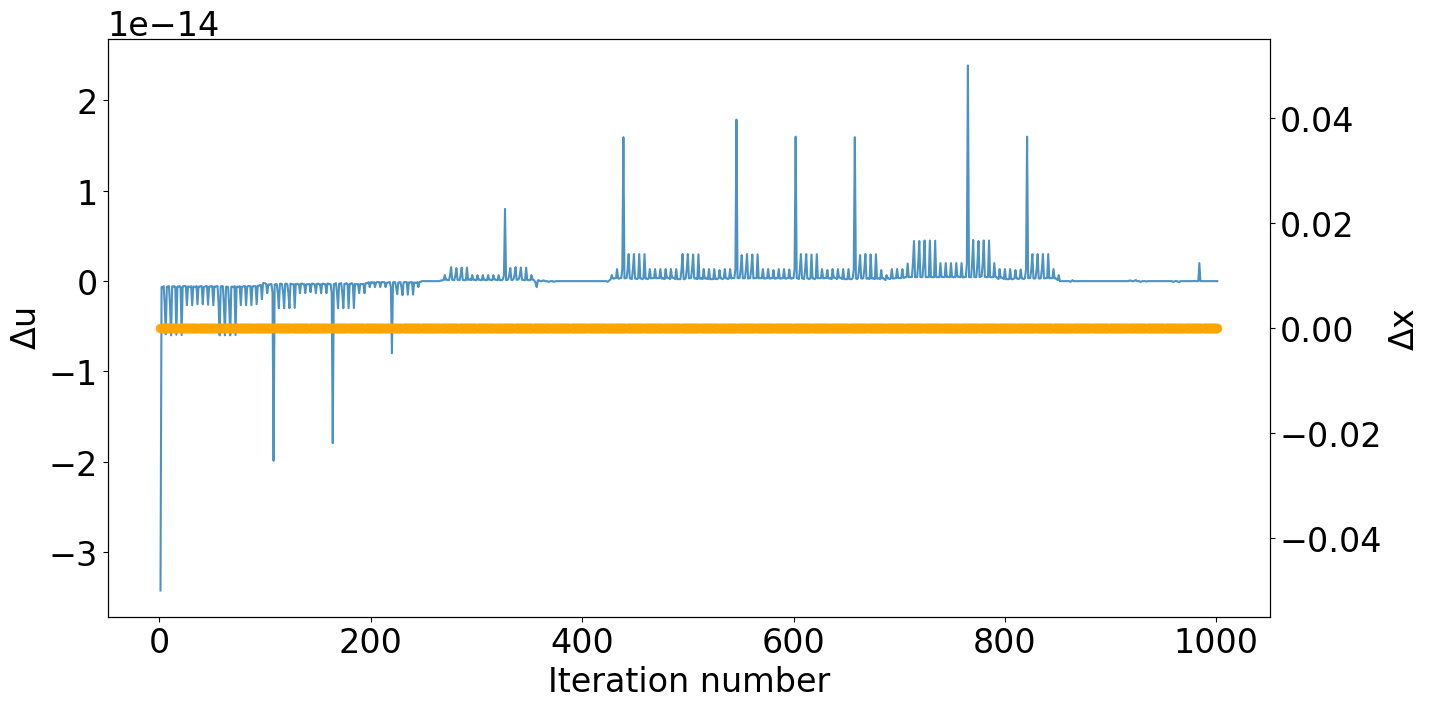

In [105]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1,n_iters+2),u-bu,alpha=0.8)
#ax2.plot(np.arange(1,n_iters+2),x, alpha=0.8,c='green')
#ax2.plot(np.arange(1,n_iters+2),bx, alpha=0.8,c='orange')
ax2.scatter(np.arange(1,n_iters+2),x-bx, alpha=0.8,c='orange')

ax1.set_xlabel('Iteration number')
ax1.set_ylabel(r'$\Delta$u')
ax2.set_ylabel(r'$\Delta$x')

plt.show()

## Bivariate example

In [119]:
np.random.seed(2022)
prbs=np.random.rand(4,4)
prbs=prbs/np.sum(prbs)
print(prbs)

[[0.00100416 0.0535481  0.01216589 0.00536213]
 [0.07354313 0.05225303 0.09631717 0.06947056]
 [0.0962427  0.07737661 0.08920288 0.08879672]
 [0.08944174 0.10268931 0.03949057 0.05309528]]


In [132]:
# demo
np.random.seed(2022)
n_iters=200
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
y=np.zeros(n_iters+1,dtype=int)+2
u=np.zeros(n_iters+1)
v=np.zeros(n_iters+1)
u[0]=np.random.rand()
v[0]=np.random.rand()

print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')   (v,y)=('+str(v[0])+','+str(y[0]+1)+')')

# forward map
for it in range(n_iters):
    # step in (x,u)
    xprbs=prbs[:,y[it]]/np.sum(prbs[:,y[it]])
    tmpx,tmpu=update(x[it],u[it],xprbs)
    x[it+1]=tmpx
    u[it+1]=tmpu
    # step in (y,v)
    yprbs=prbs[x[it+1],:]/np.sum(prbs[x[it+1],:])
    tmpy,tmpv=update(y[it],v[it],yprbs)
    y[it+1]=tmpy
    v[it+1]=tmpv
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')   (v,y)=('+str(v[-1])+','+str(y[-1]+1)+')')

Initial (u,x)=(0.009358613807764704,1)   (v,y)=(0.49905781085198797,3)
Final (u,x)=(0.12408289392805444,2)   (v,y)=(0.8520575926581329,3)


In [133]:
# backward map
bx=np.zeros(n_iters+1,dtype=int)
bu=np.zeros(n_iters+1)
by=np.zeros(n_iters+1,dtype=int)
bv=np.zeros(n_iters+1)
bu[-1]=u[-1]
bx[-1]=x[-1]
bv[-1]=v[-1]
by[-1]=y[-1]
print('Final (u,x)=('+str(bu[-1])+','+str(bx[-1]+1)+')  (v,y)=('+str(bv[-1])+','+str(by[-1]+1)+')')
for it in range(n_iters):
    tx=bx[-(it+1)]
    ty,tv=update(by[-(it+1)],bv[-(it+1)],prbs[tx,:]/np.sum(prbs[tx,:]),xi,'bwd')
    by[-(it+2)]=ty
    bv[-(it+2)]=tv
    tx,tu=update(bx[-(it+1)],bu[-(it+1)],prbs[:,ty]/np.sum(prbs[:,ty]),xi,'bwd')
    bx[-(it+2)]=tx
    bu[-(it+2)]=tu
# end for
print('Initial (u,x)=('+str(bu[0])+','+str(bx[0]+1)+')  (v,y)=('+str(bv[0])+','+str(by[0]+1)+')')

Final (u,x)=(0.12408289392805444,2)  (v,y)=(0.8520575926581329,3)
Initial (u,x)=(0.39474468641609745,3)  (v,y)=(0.8298322400944794,1)


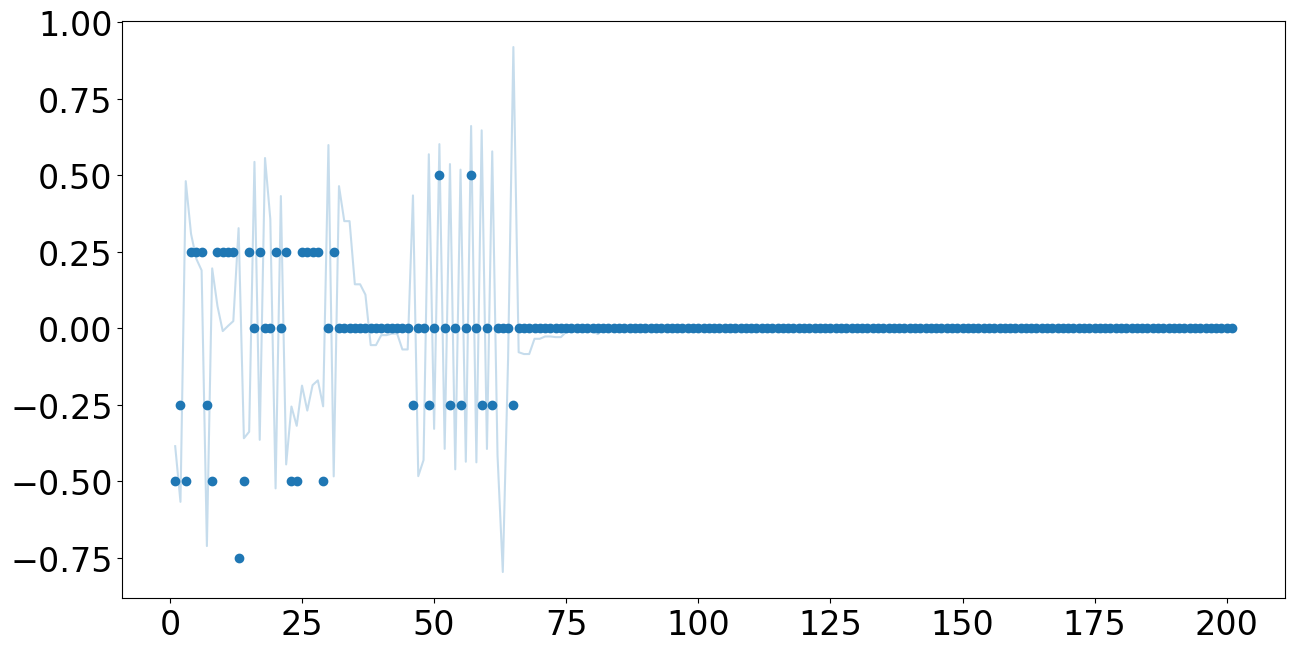

In [134]:
plt.plot(np.arange(1,n_iters+2),u-bu,alpha=0.25)
plt.scatter(np.arange(1,n_iters+2),(x-bx)/4)

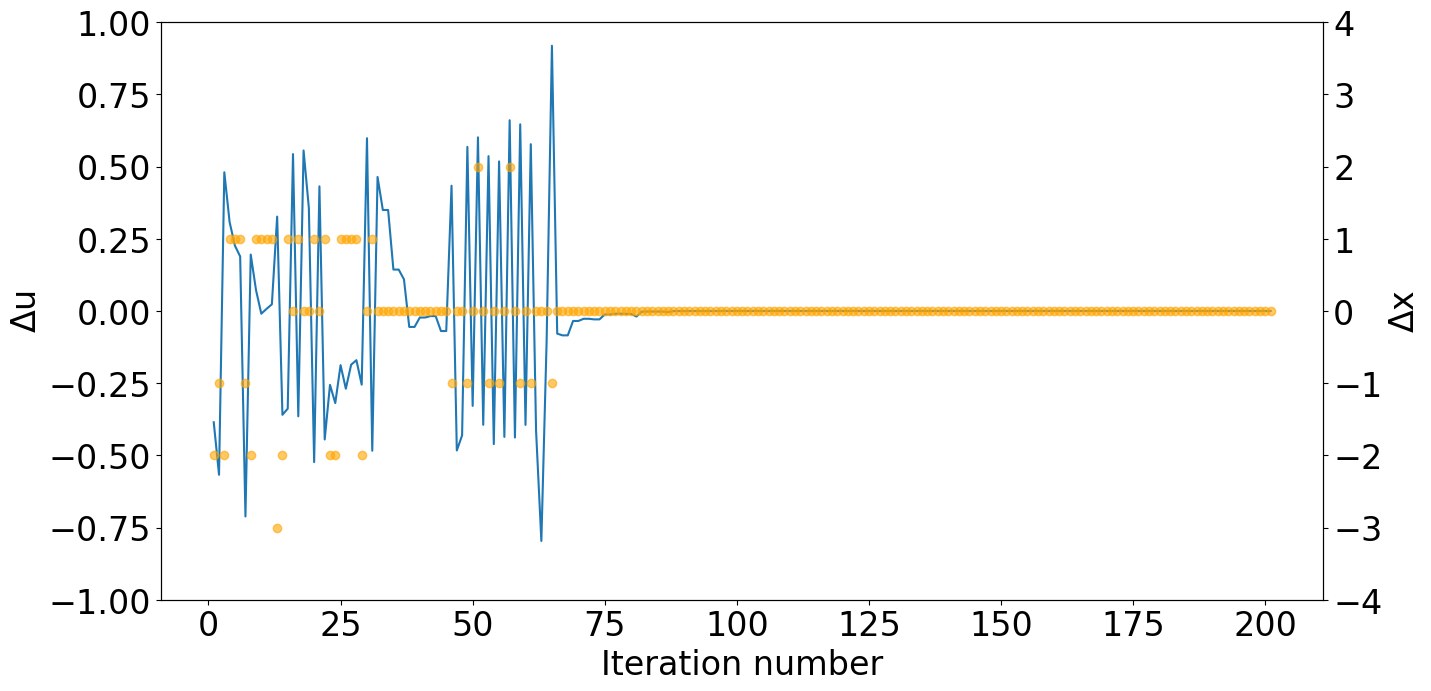

In [140]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax2.plot(np.arange(1,n_iters+2),x, alpha=0.8,c='green')
#ax2.plot(np.arange(1,n_iters+2),bx, alpha=0.8,c='orange')
ax2.scatter(np.arange(1,n_iters+2),x-bx, alpha=0.6,c='orange')
ax1.plot(np.arange(1,n_iters+2),u-bu,alpha=1)

ax1.set_xlabel('Iteration number')
ax1.set_ylabel(r'$\Delta$u')
ax1.set_ylim(-1,1)
ax2.set_ylabel(r'$\Delta$x')
ax2.set_ylim(-prbs.shape[0],prbs.shape[0])

plt.show()